In [10]:
from dotenv import load_dotenv
load_dotenv()

True

In [11]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.2-90b-vision-preview")

In [12]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper()
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

tools = [wiki]
llm_with_tools = llm.bind_tools(tools)

In [13]:
# state
from langgraph.graph import MessagesState
from typing import Annotated

def increment_track_num(orig, new):
  if orig == None: 
    return 0
  
  return orig + 1

class State(MessagesState):
  track_num: Annotated[int, increment_track_num]
  pass

In [14]:
# node
from copy import deepcopy
from langchain_core.messages import SystemMessage, HumanMessage

sys_msg = SystemMessage(content="You are a helpful assistant named Maruka that helps provide inforamtion that the user asks about by searching wikipedia documents. If there is any unknown search them again until you find the answer")

def wiki_calling_llm(state):  
  
  new_state = deepcopy(state)
  new_state['messages'] = [llm_with_tools.invoke([sys_msg] + state['messages'])]
  return new_state

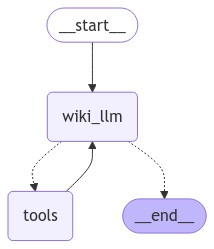

In [15]:
# graph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)

builder.add_node("wiki_llm", wiki_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "wiki_llm")
builder.add_conditional_edges("wiki_llm", tools_condition)
builder.add_edge("tools", "wiki_llm")


# memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))



In [16]:
config = {'configurable': {'thread_id': 1}}

state = {
  "messages": [HumanMessage(content="Who was the korean author who got the Nobel Prize this year (2024)?")]
}
response = graph.stream(state, config)

In [17]:
for m in response:
  print(m)

{'wiki_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7wx9', 'function': {'arguments': '{"query": "Korean Nobel Prize in Literature 2024 winner"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 336, 'total_tokens': 359, 'completion_time': 0.092, 'prompt_time': 0.084279254, 'queue_time': 0.005336131000000008, 'total_time': 0.176279254}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8962df15-f38f-43f7-9d52-22e6998e3874-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Korean Nobel Prize in Literature 2024 winner'}, 'id': 'call_7wx9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 336, 'output_tokens': 23, 'total_tokens': 359})], 'track_num': 0}}
{'tools': {'messages': [ToolMessage(content='Page: Nobel Prize in Literature\nSummary: The Nobel Prize in Literature, 

In [18]:
state = {
  "messages": [HumanMessage(content="What is your name?")]
}
for chunk in graph.stream(state, config):
  print(chunk)


{'wiki_llm': {'messages': [AIMessage(content="My name is Maruka, and I'm a helpful assistant who provides information by searching Wikipedia documents.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 2784, 'total_tokens': 2805, 'completion_time': 0.084997144, 'prompt_time': 0.662619611, 'queue_time': 0.005951798000000008, 'total_time': 0.747616755}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'stop', 'logprobs': None}, id='run-649d6b56-e3f4-4e37-8186-156c4e43807b-0', usage_metadata={'input_tokens': 2784, 'output_tokens': 21, 'total_tokens': 2805})], 'track_num': 4}}


In [25]:
state = {
  "messages": [HumanMessage(content="Oh how is this school that she taught in? Whath is the ranking of this school?")]
}

for chunk in graph.stream(state, config):
  print(chunk)


{'wiki_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_me33', 'function': {'arguments': '{"query": "Seoul Institute of the Arts ranking"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 5814, 'total_tokens': 5834, 'completion_time': 0.080041806, 'prompt_time': 1.371191254, 'queue_time': 0.006319209000000159, 'total_time': 1.45123306}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7435ceb5-2067-4570-9789-2ff0d3d3d366-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Seoul Institute of the Arts ranking'}, 'id': 'call_me33', 'type': 'tool_call'}], usage_metadata={'input_tokens': 5814, 'output_tokens': 20, 'total_tokens': 5834})], 'track_num': 17}}
{'tools': {'messages': [ToolMessage(content="Page: Seoul National University\nSummary: Seoul National University (SNU; Korean: